In [17]:
import numpy as np
import pandas as pd
import numpy as np
import os
from astropy.table import Table
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia

In [18]:
class cluster_membership: 
    
    def __init__(self, name, ra, dec, radius):
        self.name = name
        self.ra = ra
        self.dec = dec
        self.radius = radius
    
    def cone_search(self):

        gaia_query = Gaia.launch_job_async(f"""SELECT source_id, ra, ra_error, dec,\
                                 dec_error, parallax, parallax_error,\
                                 parallax_over_error, \
                                 pmra, pmra_error, pmdec, pmdec_error,\
                                 radial_velocity, radial_velocity_error,\
                                 phot_g_mean_mag, phot_bp_mean_mag,\
                                 phot_rp_mean_mag,bp_rp,\
                                 astrometric_excess_noise,\
                                 phot_bp_rp_excess_factor,\
                                 DISTANCE({ra}, {dec}, ra, dec)\
                                 FROM gaiadr3.gaia_source\
                                 WHERE DISTANCE({ra}, {dec}, ra, dec) < {radius} / 60. """,                              
                                 dump_to_file=False) 
        
        # To avoid saving the data in the server we use async
        # We filter stars with errors too large, or apparent magnitud too small 
        # Units in degrees
        # An f-string allows to embed expressions inside string literals, within {}
        
        gaia_data = gaia_query.get_results() 
        df = gaia_data.to_pandas() # convert the results in a data frame
        df = df.dropna(subset=['radial_velocity']) # Quitamos las que no tienen velocidad radial
        
        return df# We get back the data frame
    
    def pandas_to_fits(self, data_frame, name ='some_file' , reduced_df = None):

        fits_arc = Table.from_pandas(data_frame)
        fits_arc.write(name + '.fits')
    
    
    def series_str(self): 
        
        series_str = pd.Series(["parallax", "parallax_error", "pmra", "pmra_error", "pmdec", "pmdec_error", "radial_velocity", "radial_velocity_error", "phot_g_mean_mag", "bp_rp", "astrometric_excess_noise", "phot_bp_rp_excess_factor"])
        print("""The parameters for which the clusters can be filtered are: 
""",series_str)                   
        return (series_str) # We need a list with the indexes for every available parameter, so we can call them back later 
    
    def filtering (self, data_frame, series_str, ind, mini, maxi):
        
        fltd_min = data_frame[data_frame[series_str[ind]] < maxi ]
        fltd = fltd_min[mini < fltd_min[series_str[ind]]] # We filtered the data of the defined parameter between the defined limits

        return fltd # The reduced data frame
    
    def plot_one_set (self, data_frame, series_str, indx, indy, reduced_data_frame = None, xtext = 'x data', ytext = 'y data', xlimit = None, ylimit = None, savefig=False):

        # data_frame["phot_g_mean_mag"] =+ (5 * np.log10(data_frame["parallax"]/100)
        
        x_data = data_frame[series_str[indx]]
        y_data = data_frame[series_str[indy]]
        
        fig = plt.figure(figsize = (8, 6))
        gs = fig.add_gridspec(4, 4)  # Create a grid of subplots

        ax_main = fig.add_subplot(gs[1:4, 0:3]) # Place of the main plot in the grid of subplots

        ax_main.scatter(x_data , y_data, s = 7, c = 'darkorange')
        
        ax_hist_x = fig.add_subplot(gs[0, 0:3], sharex=ax_main) # Place of both histograms in the grid
        ax_hist_y = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

        ax_hist_x.get_xaxis().set_visible(False) # Hide certain axes
        ax_hist_y.get_yaxis().set_visible(False)
        
        bin_width_x = 0.001
        bin_width_y = 0.001

        bins_x = 80
        bins_y = 80
        # bins_x = np.arange(min(x_data), max(x_data) + bin_width_x, bin_width_x)
        # bins_y = np.arange(min(y_data), max(y_data) + bin_width_y, bin_width_y)  
        
        ax_hist_x.hist(x_data, bins = bins_x, color='darkorange', alpha=0.5)
        ax_hist_y.hist(y_data, bins = bins_y, color='darkorange', alpha=0.5, orientation='horizontal')

        if reduced_data_frame is not None: 

            # reduced_data_frame["phot_g_mean_mag"] =+ 5 * np.log10(reduced_data_frame["parallax"]/100) 
            x_data_reduced = reduced_data_frame[series_str[indx]]
            y_data_reduced = reduced_data_frame[series_str[indy]]
            
            ax_main.scatter(x_data_reduced, y_data_reduced, s = 7, c = 'purple') # Extra scatterplot for an additional set of data

            # bins_x = np.arange(min(x_data_reduced), max(x_data_reduced) + bin_width_x, bin_width_x)
            # bins_y = np.arange(min(y_data_reduced), max(y_data_reduced) + bin_width_y, bin_width_y)  
            
            ax_hist_x.hist(x_data_reduced, bins= bins_x, color='purple', alpha=0.5)
            ax_hist_y.hist(y_data_reduced, bins= bins_y, color='purple', alpha=0.5, orientation='horizontal')

        ax_main.tick_params(axis='both', labelsize=10)  # Main plot tick labels
        ax_hist_x.tick_params(axis='y', labelsize=10)  # histograms tick labels
        ax_hist_y.tick_params(axis='x', labelsize=10) 

        # fig.suptitle(f'Datos d: {name}', fontsize = 18)
        fig.tight_layout()
        fig.subplots_adjust(hspace=0.3,wspace=0.3)
                          
        ax_main.set_xlabel (xtext, fontsize = 18)
        ax_main.set_ylabel (ytext, fontsize = 18)

        if xlimit is not None:
            
            ax_main.set_xlim(xlimit[0], xlimit[1]) # Available option of setting the limits of the figure
            
        if ylimit is not None:
            
            ax_main.set_ylim(ylimit[0], ylimit[1])
            
        if savefig == True: 

            path = input ('Path of the saved figure: ') # Available option of saving the figure as a pdf
            file_name = input ('Name of the figure: ')
            full_path = os.path.join(path, file_name)
            os.makedirs(path, exist_ok=True)
            plt.savefig(full_path, format='pdf', bbox_inches='tight')

        plt.show()

        if reduced_data_frame is None:
                
            print('The number of stars in the diagram is ',len(data_frame)) # We print the number of stars of the defined set

        if reduced_data_frame is not None: 

            print('The number of stars in the diagram from the first set is ',len(data_frame))
            print('The number of stars in the diagram from the second set is ',len(reduced_data_frame))

    def mag_abs(self,data_frame, reduced_data_frame = None, fix_parallax = False):

        if reduced_data_frame is None: 
            
            if fix_parallax == False:

                data_frame["phot_g_mean_mag"] = data_frame["phot_g_mean_mag"] + (5 * np.log10(data_frame["parallax"]/100)) # Transform the apparent magnitud into absolute magnitud
    
            if fix_parallax == True:
                fixed_par = input('The literature parallax of the studied cluster is: ')
                data_frame["phot_g_mean_mag"] = data_frame["phot_g_mean_mag"] + (5 * np.log10(float(fixed_par)/100.))

            return(data_frame)
        
        if reduced_data_frame is not None: 
            
            if fix_parallax == False:
                data_frame["phot_g_mean_mag"] = data_frame["phot_g_mean_mag"] + (5 * np.log10(data_frame["parallax"]/100)) # Transform the apparent magnitud into absolute magnitud
                reduced_data_frame["phot_g_mean_mag"] = reduced_data_frame["phot_g_mean_mag"] + (5 * np.log10(data_frame["parallax"]/100))

            if fix_parallax == True:
                fixed_par = input('The literature parallax of the studied cluster is: ')
                data_frame["phot_g_mean_mag"] = data_frame["phot_g_mean_mag"] + (5 * np.log10(float(fixed_par)/100.))
                reduced_data_frame["phot_g_mean_mag"] = reduced_data_frame["phot_g_mean_mag"] + (5 * np.log10(float(fixed_par)/100.))

            return(data_frame, reduced_data_frame)

    def plot_cm_diagram(self, data_frame, reduced_data_frame = None, savefig = False, xlimit = None, ylimit = None, histograms = True):
    # Very similar function to the previous one, only specific for CM diagrams exclusively. Additional option of hiding the histograms.
        
        if histograms == True: 

            y_data = data_frame["phot_g_mean_mag"]
            x_data = data_frame["bp_rp"]
            
            fig = plt.figure(figsize = (8,6))
            gs = fig.add_gridspec(4, 4)

            ax_main = fig.add_subplot(gs[1:4, 0:3])
            
            ax_main.scatter(x_data, y_data, s = 7, c = 'darkorange')
            
            ax_hist_x = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
            ax_hist_y = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
            
            ax_hist_x.get_xaxis().set_visible(False)
            ax_hist_y.get_yaxis().set_visible(False)

            # bin_width_x = 0.2
            # bin_width_y = 0.1
            
            # bins_x = np.arange(min(x_data), max(x_data) + bin_width_x, bin_width_x)
            # bins_y = np.arange(min(y_data), max(y_data) + bin_width_y, bin_width_y)

            bins_x = 80
            bins_y = 80
            
            ax_hist_x.hist(x_data, bins = bins_x, color='darkorange', alpha = 0.5)
            ax_hist_y.hist(y_data, bins = bins_y, color='darkorange', alpha = 0.5, orientation='horizontal')

            if reduced_data_frame is not None:

                y_data_reduced = reduced_data_frame["phot_g_mean_mag"]
                x_data_reduced = reduced_data_frame["bp_rp"]

                ax_main.scatter(x_data_reduced, y_data_reduced, s = 7, c = 'purple')
                
                # bins_x = np.arange(min(x_data_reduced), max(x_data_reduced) + bin_width_x, bin_width_x)
                # bins_y = np.arange(min(y_data_reduced), max(y_data_reduced) + bin_width_y, bin_width_y)
                
                ax_hist_x.hist(x_data_reduced, bins = bins_x , color='purple', alpha=0.5)
                ax_hist_y.hist(y_data_reduced, bins = bins_y , color='purple', alpha=0.5, orientation='horizontal')

            ax_main.tick_params(axis='both', labelsize=10)  # Main plot tick labels
            ax_hist_x.tick_params(axis='y', labelsize=10)  # X-axis histograms tick labels
            ax_hist_y.tick_params(axis='x', labelsize=10)  # Y-axis histograms tick labels
            
            ax_main.invert_yaxis()
            fig.suptitle(f'Diagrama HR del cúmulo: {name}', fontsize = 18)
            fig.tight_layout()
            fig.subplots_adjust(hspace=0.3,wspace=0.3)
            ax_main.set_xlabel (r'$G_{BP}-G_{RP}$', fontsize = 18)
            ax_main.set_ylabel (r'$M_G$', fontsize = 18)

            if xlimit is not None:
            
                ax_main.set_xlim(xlimit[0], xlimit[1])
            
            if ylimit is not None:
            
                ax_main.set_ylim(ylimit[0], ylimit[1])
            
            if savefig == True: 

                path = input ('Path of the saved figure: ')
                file_name = input ('Name of the figure: ')
                full_path = os.path.join(path, file_name)
                os.makedirs(path, exist_ok=True)
                plt.savefig(full_path, format='pdf', bbox_inches='tight')

            plt.show()

            if reduced_data_frame is None:
                
                print('The number of stars in the diagram is ',len(data_frame))

            if reduced_data_frame is not None: 

                print('The number of stars in the diagram from the first set is ',len(data_frame))
                print('The number of stars in the diagram from the second set is ',len(reduced_data_frame))
                

        if histograms == False:
                
            y_data = data_frame["phot_g_mean_mag"]
            x_data = data_frame["bp_rp"]
            
            fig = plt.figure(figsize = (8,6))
            plt.scatter(x_data, y_data, s = 7, c = 'darkorange')

            if reduced_data_frame is not None:
                    
                y_data_reduced = reduced_data_frame["phot_g_mean_mag"]
                x_data_reduced = reduced_data_frame["bp_rp"]

                plt.scatter(x_data_reduced, y_data_reduced, s = 7, c = 'purple')
            
            plt.tick_params(axis='both', labelsize=10)  # Main plot tick labels
                
            plt.gca().invert_yaxis()            
            plt.suptitle(f'Diagrama HR del cúmulo: {name}', fontsize = 18)
            plt.tight_layout()
            plt.subplots_adjust(hspace=0.3,wspace=0.3)
            plt.xlabel (r'$G_{BP}-G_{RP}$', fontsize = 18)
            plt.ylabel (r'$M_G$', fontsize = 18)
            
            if xlimit is not None:
            
                plt.xlim(xlimit[0], xlimit[1])
            
            if ylimit is not None:
            
                plt.ylim(ylimit[0], ylimit[1])
            
            if savefig == True: 

                path = input ('Path of the saved figure: ')
                file_name = input ('Name of the figure: ')
                full_path = os.path.join(path, file_name)
                os.makedirs(path, exist_ok=True)
                plt.savefig(full_path, format='pdf', bbox_inches='tight')

            plt.show()

            if reduced_data_frame is None:
                
                print('The number of stars in the diagram is ',len(data_frame))

            if reduced_data_frame is not None: 

                print('The number of stars in the diagram from the first set is ',len(data_frame))
                print('The number of stars in the diagram from the second set is ',len(reduced_data_frame))
                
    def help(self): # Extra function that explains how each function of the program work
        
        print("""
        cone_search: Performs the cone search query for the specified coordinates and provides: data frame with all the parameters, parallax, proper motion in right ascension and declination, magnitud in g band, color BP-RP, radial velocity
        
        cone_search_errors: Performs the same cone search and provides the data frame, errors for every parameter listed above, apart from astrometric exccess noise and photometric excess factor
        
        series_str: Provides a list with the indexes of every parameter, so it can be used in the analysis functions
        
        filtering: Filters the data for the parameter specified by the index, and for the specified limits
        
        plot_sets: Provides a figure comparing the values of two different parameters specified by the index for every star, for one or two sets
        
        plot_cm_diagram: Provides a fig
        
        """)

In [19]:
name = 'M54' # Simbad info
ra = 283.764 # degrees
dec = -30.480 # degrees
radius = 14./2. #arcmin 

M54 = cluster_membership(name, ra, dec, radius)

data_frame = M54.cone_search()

INFO: Query finished. [astroquery.utils.tap.core]


In [20]:
indexes = M54.series_str()

The parameters for which the clusters can be filtered are: 
 0                     parallax
1               parallax_error
2                         pmra
3                   pmra_error
4                        pmdec
5                  pmdec_error
6              radial_velocity
7        radial_velocity_error
8              phot_g_mean_mag
9                        bp_rp
10    astrometric_excess_noise
11    phot_bp_rp_excess_factor
dtype: object


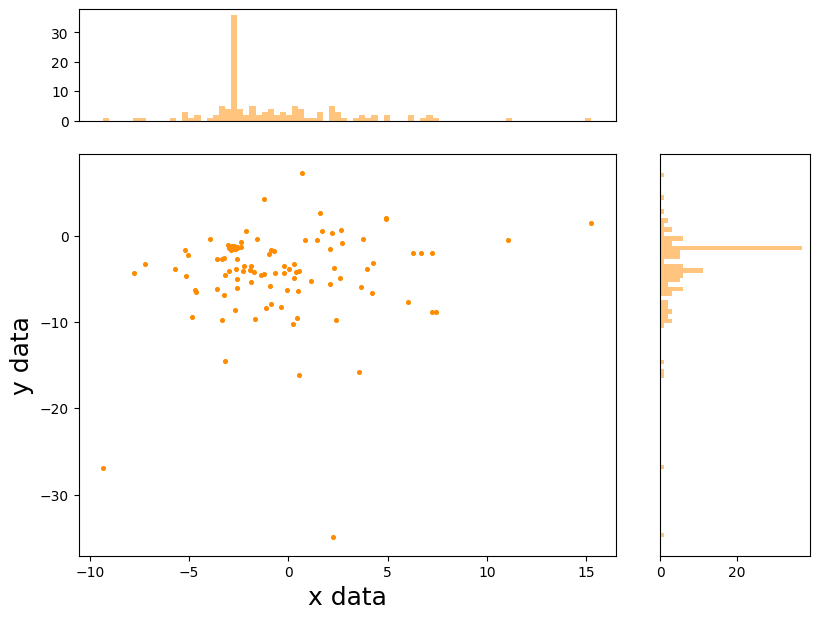

The number of stars in the diagram is  124


In [21]:
M54.plot_one_set(data_frame, indexes, 2,4)

In [22]:
data_pm = M54.filtering(data_frame, indexes, 2, -2.779, -2.579)
data_pm = M54.filtering(data_pm, indexes, 4, -1.487, -1.287)

In [24]:
# M54.pandas_to_fits(data_pm, name = 'filt_20_estrellasss')

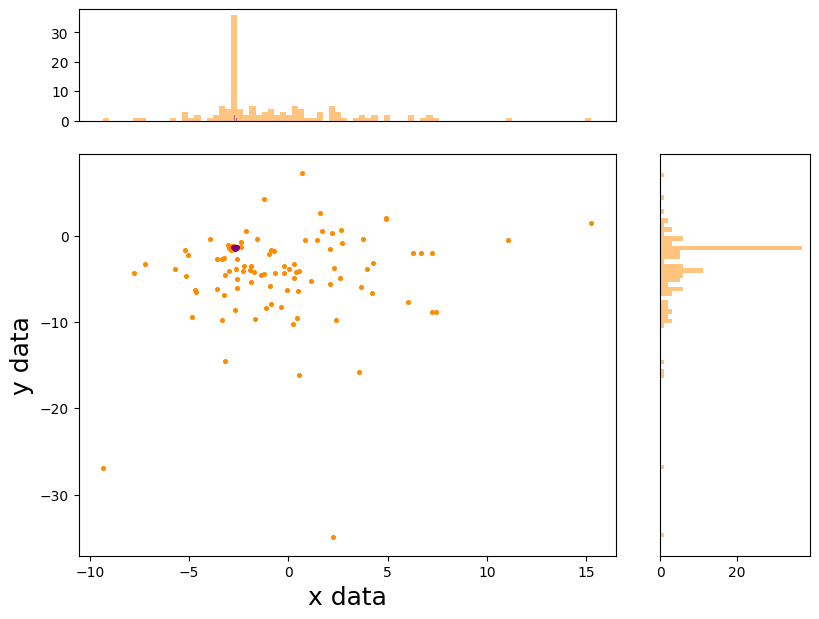

The number of stars in the diagram from the first set is  124
The number of stars in the diagram from the second set is  20


In [25]:
M54.plot_one_set(data_frame, indexes, 2,4, data_pm)

In [26]:
final_frame, final_frame_red = M54.mag_abs(data_frame, data_pm, fix_parallax = True)

The literature parallax of the studied cluster is:  0.053


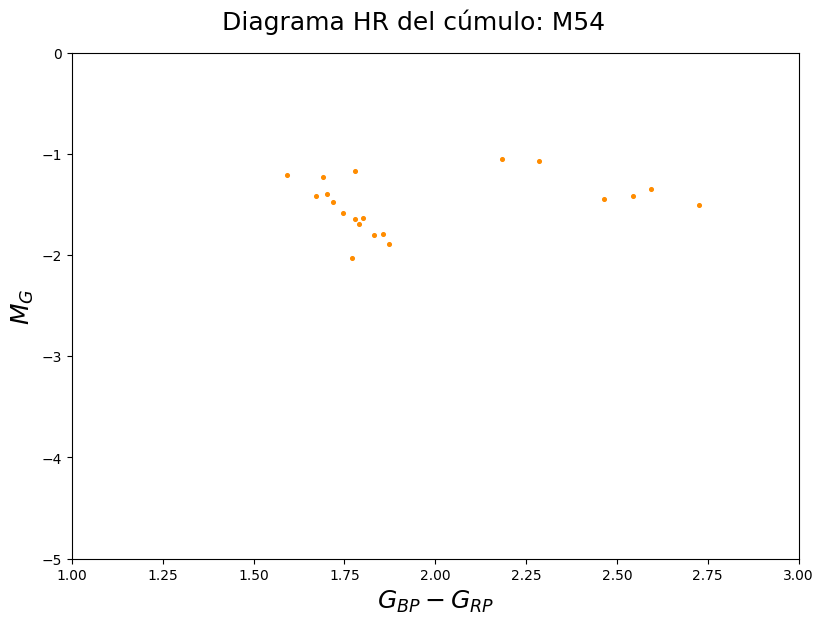

The number of stars in the diagram is  20


In [30]:
M54.plot_cm_diagram(final_frame_red, xlimit = [1,3], ylimit = [-5,0], histograms = False)